In [1]:
# importing all the necessary libraries
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import model_selection as ms
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
import time
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble
from sklearn.model_selection import cross_val_score as cs
from sklearn.model_selection import KFold
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.metrics import accuracy_score as ac

In [2]:
# fetching the dataset
oliv=datasets.fetch_olivetti_faces()
oliv.keys()

dict_keys(['data', 'images', 'target', 'DESCR'])

In [3]:
oliv['data'].shape, oliv['images'].shape

((400, 4096), (400, 64, 64))

In [4]:
# funtion for plotting important elements
def plotting_fig(s):
    fig=plt.figure(figsize=(7,7))
    for i in range(49):
        ax=fig.add_subplot(7,7,i+1)
        ax.imshow(s[i], cmap=plt.cm.bone)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

In [5]:
# plotting the predicted values along with true values
def plot_gallery(images,titles,h,w,row=3,col=11):
    plt.figure(figsize=(1.4*col,2*row))
    plt.subplots_adjust(bottom=0,left=0.1,right=.99,top=0.80,hspace=.35)
    for i in range(33):
        plt.subplot(row,col,i+1)
        plt.imshow(images[i].reshape((64,64)),cmap=plt.cm.bone)
        plt.title(titles[i],size=12)
        plt.xticks([])
        plt.yticks([])
def title(y_pred,y_test,i):
    return 'predicted: %s\n true: %s'%(y_pred[i],y_test[i])

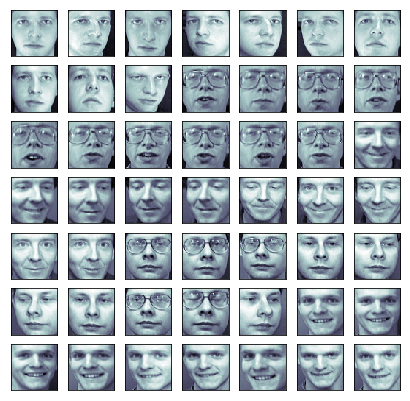

In [6]:
plotting_fig(oliv.images)    # plotting original dataset

In [7]:
x=oliv.data
y=oliv.target

In [8]:
x.shape, y.shape

((400, 4096), (400,))

In [9]:
# data one hot encoded for tensor flow
onehot_encoder = OneHotEncoder(sparse=False)
one_hot_encoded = y.reshape(400, 1)
y_one_hot_encoded = onehot_encoder.fit_transform(one_hot_encoded)


C:\Users\swaga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [10]:
y_one_hot_encoded.shape

(400, 40)

In [11]:
# splitting the data
x_train,x_test,y_train_one_hot,y_test_one_hot= ms.train_test_split(x,y_one_hot_encoded,random_state=1)
x_train,x_test,y_train,y_test= ms.train_test_split(x,y,random_state=1)

In [12]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape, y_train_one_hot.shape, y_test_one_hot.shape

((300, 4096), (300,), (100, 4096), (100,), (300, 40), (100, 40))

In [13]:
# running principle component analysis for finding number of components
pca=PCA()
pca.fit(x_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [14]:
# calculating number of features to be kept for 95% variance
k=0
total=sum(pca.explained_variance_)
current_sum=0
while current_sum/total<0.95:
    current_sum+=pca.explained_variance_[k]
    k=k+1
k

107

In [15]:
# running PCA provided with number of components to retain
pca=PCA(n_components=k,whiten= True)
x_transformed=pca.fit_transform(x_train)
x_transformed.shape

(300, 107)

In [16]:
x_train_pca=x_transformed

In [17]:
x_test_pca= pca.transform(x_test)
x_test_pca.shape

(100, 107)

In [18]:
x_approx= pca.inverse_transform(x_transformed)
x_approx= x_approx.reshape((300,64,64))

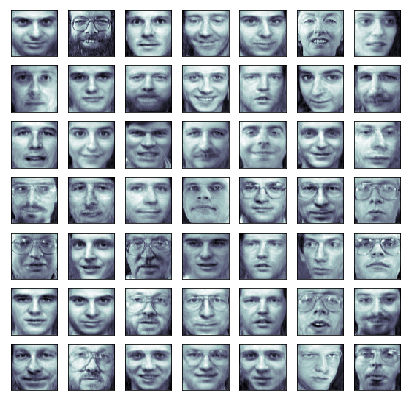

In [19]:
plotting_fig(x_approx)      # images after keeping only 95% of varience  

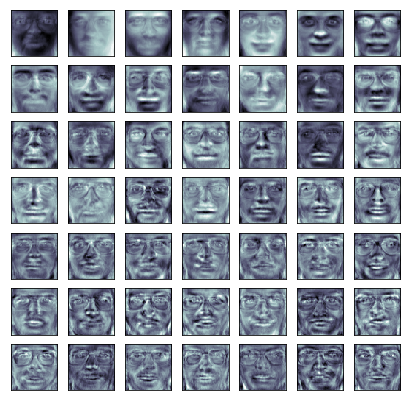

In [20]:
eig_v= pca.components_.reshape((k,64,64))   # regenerated images from principle components only
plotting_fig(eig_v)

# Using various Regression and Classification techniques to solve the desired problem

## 1. NEURAL NETWORK (Tenserflow) 

### Without using PCA

In [21]:
sess=tf.Session()

In [22]:
n_ip=4096
n_hidden1= 1000
n_hidden2= 1000
n_classes= 40

In [23]:
wts={ "h1": tf.Variable(tf.random_normal([n_ip,n_hidden1])), "h2": tf.Variable(tf.random_normal([n_hidden1,n_hidden2])), 
    "out": tf.Variable(tf.random_normal([n_hidden2,n_classes]))}

In [24]:
bias={ "h1": tf.Variable(tf.random_normal([n_hidden1])), "h2": tf.Variable(tf.random_normal([n_hidden2])), 
    "out": tf.Variable(tf.random_normal([n_classes]))}

In [25]:
# forward propogation of the data
def frwd_p(x,wts,bias):
    in_layer1= tf.add(tf.matmul(x,wts["h1"]),bias["h1"])
    o_layer1= tf.nn.relu(in_layer1)
    in_layer2= tf.add(tf.matmul(o_layer1,wts["h2"]),bias["h2"])
    o_layer2= tf.nn.relu(in_layer2)
    out= tf.add(tf.matmul(o_layer2,wts["out"]),bias["out"])    
    return out   

In [26]:
sess.run(tf.global_variables_initializer())
x1= tf.placeholder('float',[None,n_ip])
y1= tf.placeholder(tf.int32,[None,n_classes])

In [27]:
pred= frwd_p(x1,wts,bias)
predictions= tf.argmax(pred,1)
true_labels= tf.argmax(y1,1)
correct_pred= tf.equal(predictions,true_labels)

In [28]:
start=time.time()
predictions_eval,labels,correct_pred1= sess.run([predictions,true_labels,correct_pred],
                                               feed_dict={x1:x_test, y1:y_test_one_hot})
end=time.time()

In [29]:
print('Total correct predictions ',correct_pred1.sum())

Total correct predictions  7


In [30]:
print('Accuracy ',correct_pred1.sum()/len(y_test))
print('Time taken is ',(end-start))

Accuracy  0.07
Time taken is  0.25092601776123047


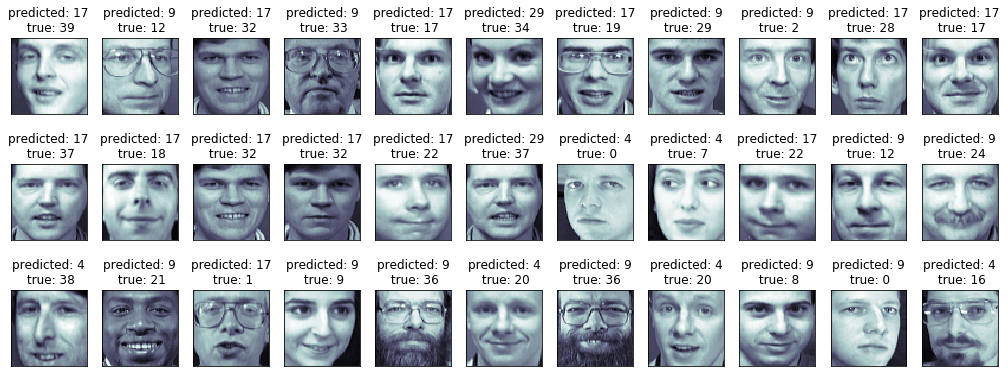

In [31]:
# showing comparison of actual values with predicted ones (can only show 33 comparison)
prediction1 = [title(predictions_eval,y_test,i) for i in range(predictions_eval.shape[0])]
plot_gallery(x_test,prediction1,64,64)

### With PCA

In [32]:
n_ip=k
n_hidden1= 100
n_hidden2= 70
n_classes= 40

In [33]:
wts={ "h1": tf.Variable(tf.random_normal([n_ip,n_hidden1])), "h2": tf.Variable(tf.random_normal([n_hidden1,n_hidden2])), 
    "out": tf.Variable(tf.random_normal([n_hidden2,n_classes]))}

In [34]:
bias={ "h1": tf.Variable(tf.random_normal([n_hidden1])), "h2": tf.Variable(tf.random_normal([n_hidden2])), 
    "out": tf.Variable(tf.random_normal([n_classes]))}

In [35]:
#forward propogation
def frwd_p(x,wts,bias):
    in_layer1= tf.add(tf.matmul(x,wts["h1"]),bias["h1"])
    o_layer1= tf.nn.relu(in_layer1)
    in_layer2= tf.add(tf.matmul(o_layer1,wts["h2"]),bias["h2"])
    o_layer2= tf.nn.relu(in_layer2)
    out= tf.add(tf.matmul(o_layer2,wts["out"]),bias["out"])
    return out 

In [36]:
sess.run(tf.global_variables_initializer())
x1= tf.placeholder('float',[None,n_ip])
y1= tf.placeholder(tf.int32,[None,n_classes])

In [37]:
pred= frwd_p(x1,wts,bias)
predictions= tf.argmax(pred,1)
true_labels= tf.argmax(y1,1)
correct_pred= tf.equal(predictions,true_labels)

In [38]:
start=time.time()
predictions_eval,labels,correct_pred1= sess.run([predictions,true_labels,correct_pred],
                                               feed_dict={x1:x_test_pca, y1:y_test_one_hot})
end=time.time()

In [39]:
print('Total correct predicted values',correct_pred1.sum())

Total correct predicted values 1


In [40]:
print('Accuracy ',correct_pred1.sum()/len(y_test))
print('Time taken is',(end-start))

Accuracy  0.01
Time taken is 0.022998809814453125


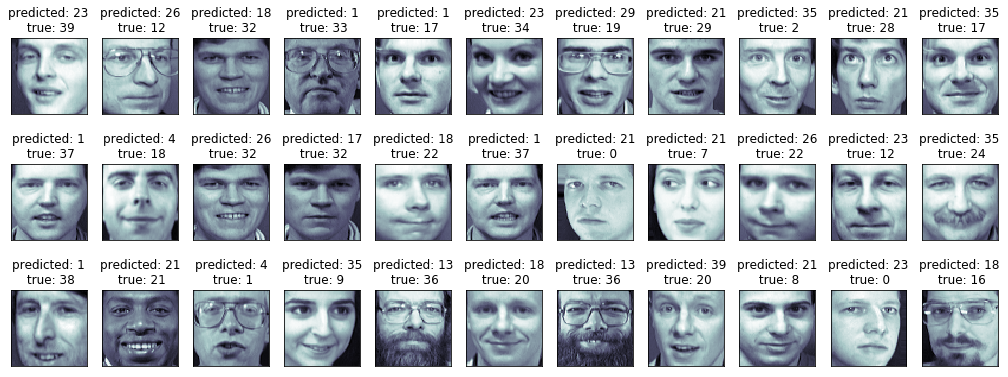

In [41]:
# showing comparison of actual values with predicted ones
prediction1 = [title(predictions_eval,y_test,i) for i in range(predictions_eval.shape[0])]
plot_gallery(x_test,prediction1,64,64)

## 2. RANDOM FOREST

### Without using PCA

In [42]:
rf= ensemble.RandomForestClassifier()
start=time.time()
rf.fit(x_train, y_train)
end=time.time()
y_pred= rf.predict(x_test)
print('Accuracy score is ',rf.score(x_test,y_test))
print('Time taken is ',(end-start))


C:\Users\swaga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy score is  0.68
Time taken is  0.2689852714538574


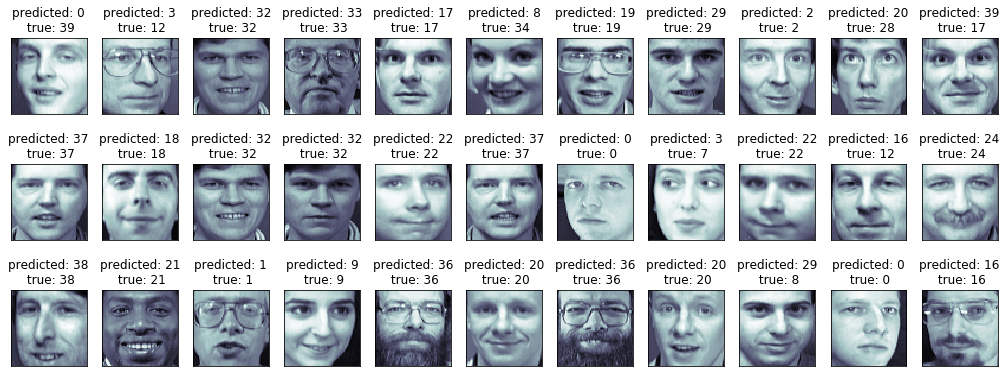

In [43]:
# showing comparison of actual values with predicted ones
prediction2 = [title(y_pred,y_test,i) for i in range(y_pred.shape[0])]
plot_gallery(x_test,prediction2,64,64)

### With PCA

In [44]:
start=time.time()
rf.fit(x_train_pca, y_train)
end=time.time()
y_pred= rf.predict(x_test_pca)
print('Accuracy score is ',rf.score(x_test_pca,y_test))
print('Time taken is ',(end-start))

Accuracy score is  0.65
Time taken is  0.06502819061279297


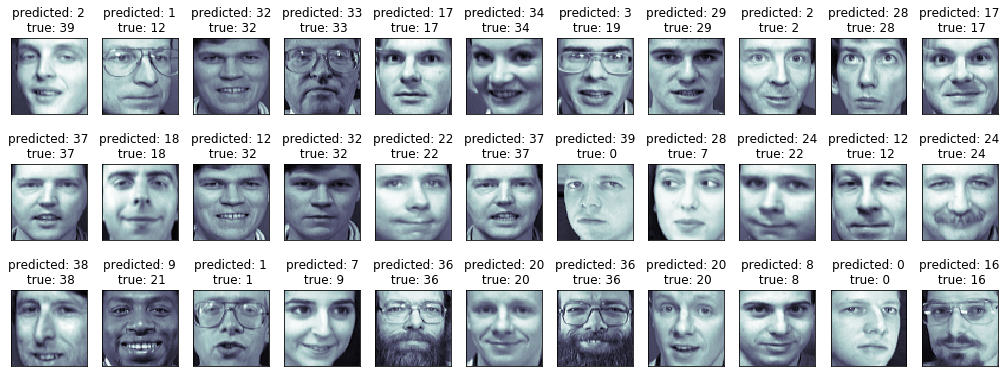

In [45]:
# showing comparison of actual values with predicted ones
prediction3 = [title(y_pred,y_test,i) for i in range(y_pred.shape[0])]
plot_gallery(x_test,prediction3,64,64)

## 3. SVM

### Without using PCA

In [46]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
clf=svm.SVC()
grid={"C":[1e2, 1e3, 5e3, 1e4, 5e4, 1e5], "gamma": [1e-3, 5e-4, 1e-4, 5e-3]}
abc=GridSearchCV(clf,grid)


In [47]:
start=time.time()
abc.fit(x_train, y_train)
end=time.time()
pred=abc.predict(x_test)
abc.best_estimator_

C:\Users\swaga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\swaga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [48]:
print('Accuracy score is ',abc.score(x_test,y_test))
print('Time taken is',(end-start))

Accuracy score is  0.96
Time taken is 60.20769286155701


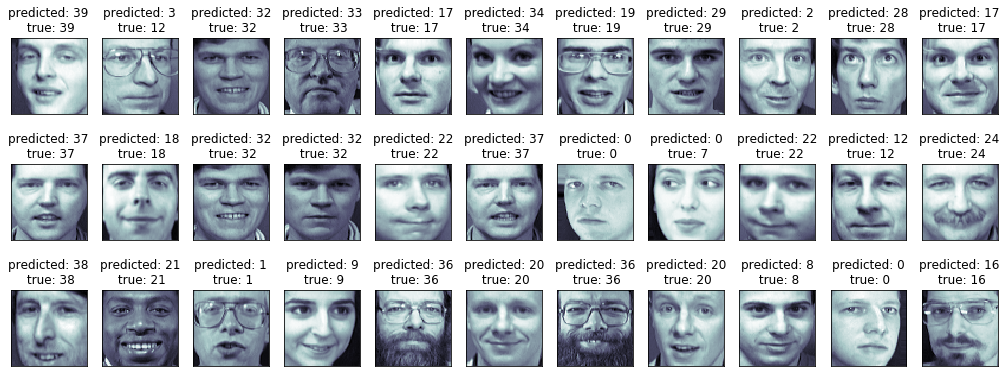

In [49]:
#showing comparison of actual values with predicted ones
prediction = [title(pred,y_test,i) for i in range(pred.shape[0])]
plot_gallery(x_test,prediction,64,64)

### With PCA

In [50]:
start=time.time()
abc.fit(x_train_pca, y_train)
end=time.time()
pred=abc.predict(x_test_pca)

C:\Users\swaga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\swaga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [51]:
print('Accuracy score is ',abc.score(x_test_pca,y_test))
print('Time taken is',(end-start))

Accuracy score is  0.95
Time taken is 3.1468286514282227


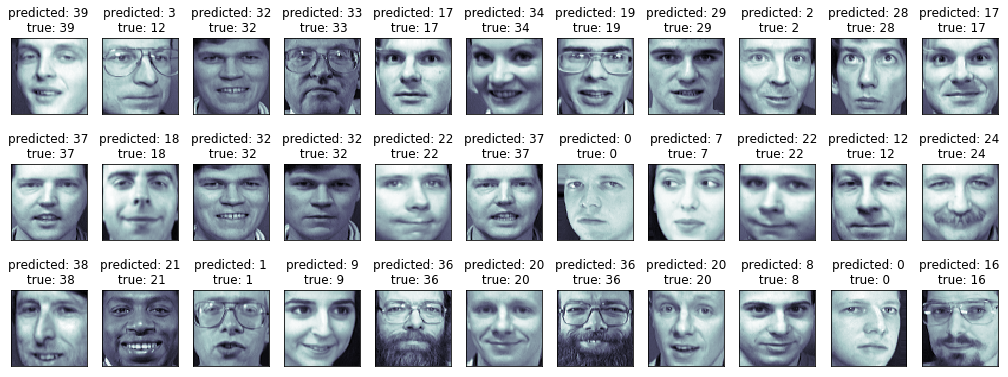

In [52]:
# showing comparison of actual values with predicted ones
prediction = [title(pred,y_test,i) for i in range(pred.shape[0])]
plot_gallery(x_test,prediction,64,64)

## 4. LINEAR REGRESSION

### Without PCA

In [53]:
from sklearn.linear_model import LinearRegression as lr

In [54]:
algo=lr()
start=time.time()
algo.fit(x_train,y_train)
end=time.time()
y_p=algo.predict(x_test)

In [55]:
y_p_i=[int(i) for i in y_p]
y_p_i=np.array(y_p_i)

In [56]:
print('Accuracy score is ',algo.score(x_test,y_test))
print('Time taken is',(end-start))

Accuracy score is  0.6131485552590178
Time taken is 0.10299396514892578


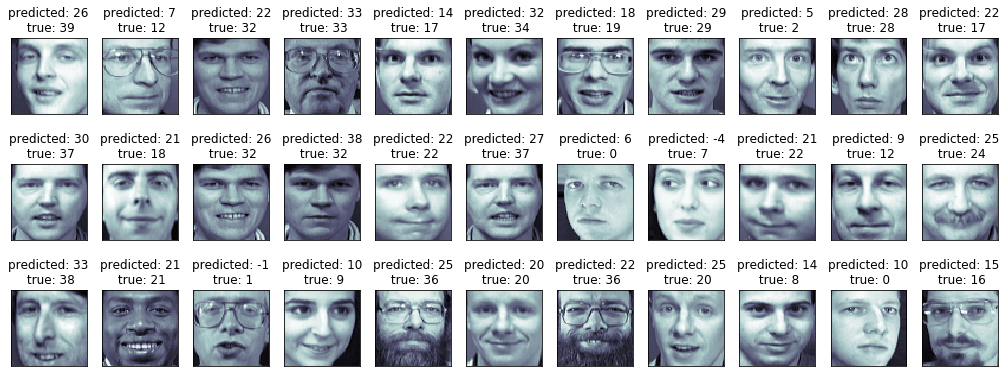

In [57]:
# showing comparison of actual values with predicted ones
prediction4 = [title(y_p_i,y_test,i) for i in range(y_p_i.shape[0])]
plot_gallery(x_test,prediction4,64,64)

### With PCA

In [58]:
start=time.time()
algo.fit(x_train_pca,y_train)
end=time.time()
y_p=algo.predict(x_test_pca)

In [59]:
print('Accuracy score is',algo.score(x_test_pca,y_test))
print('Time taken is',(end-start))

Accuracy score is 0.5178007809416802
Time taken is 0.006001949310302734


In [60]:
y_p_i=[int(i) for i in y_p]
y_p_i=np.array(y_p_i)

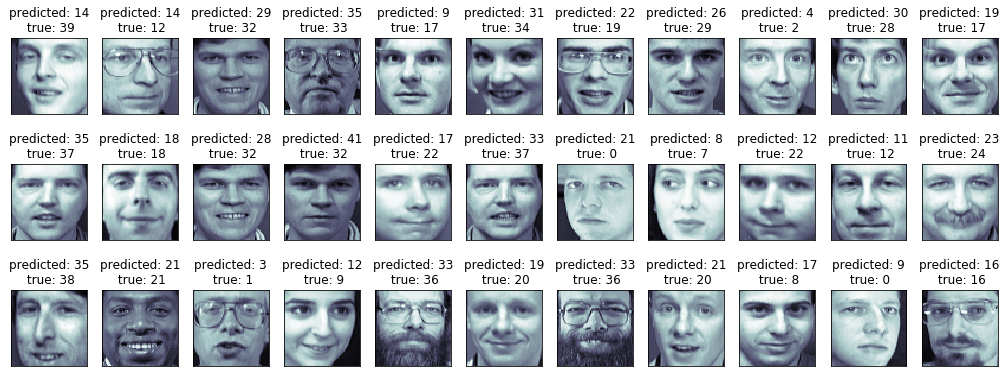

In [61]:
# showing comparison of actual values with predicted ones
prediction5 = [title(y_p_i,y_test,i) for i in range(y_p_i.shape[0])]
plot_gallery(x_test,prediction5,64,64)

## 5. KNN (self implemented)

### Without using PCA

In [62]:
for i in range(1,10,2):
    clf=knn(n_neighbors =i)
    score= cs(clf,x_train,y_train,cv=KFold(5,True,0))
    print(i,score.mean())

1 0.8799999999999999
3 0.7833333333333334
5 0.6966666666666667
7 0.6566666666666666
9 0.5966666666666667


In [63]:
# predicting class of current row of features
def predict_one(x1,x_train,y_train,k):
    distances=[]
    y=[]
    for i in range(len(x_train)):
        distance= ((x_train[i,:]-x1)**2).sum()
        distances.append([distance,i])
    distances=sorted(distances)
    for j in range(k):
        index_= distances[j][1]
        y.append(y_train[index_])
    return Counter(y).most_common(1)[0][0]

In [64]:
# predict function
def predict(x_test,x_train,y_train,k):
    y_pred=[]
    for i in x_test:
        y_pred.append(predict_one(i,x_train,y_train,k))
    return y_pred

In [65]:
k=1
start=time.time()
y_pred1=predict(x_test,x_train,y_train,k)
end=time.time()

In [66]:
print('Accuracy score is',ac(y_test,y_pred1))
print('Time taken is',(end-start))

Accuracy score is 0.89
Time taken is 0.7629978656768799


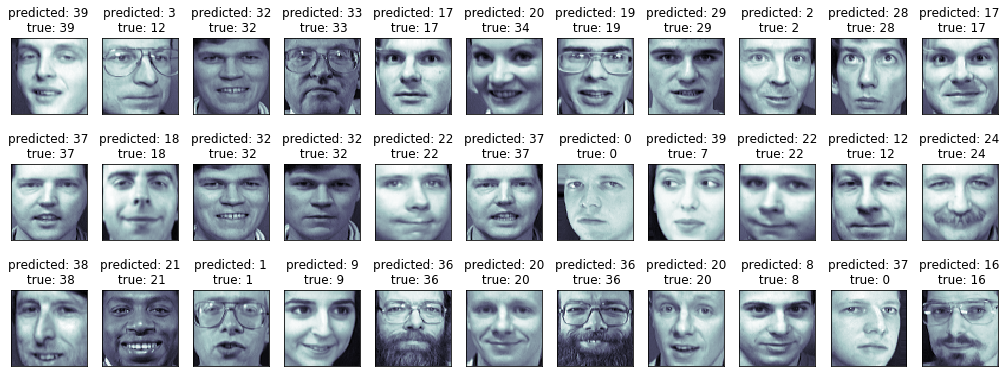

In [67]:
# showing comparison of actual values with predicted ones
y_pred1=np.array(y_pred1)
prediction6 = [title(y_pred1,y_test,i) for i in range(y_pred1.shape[0])]
plot_gallery(x_test,prediction6,64,64)

### With PCA

In [68]:
start=time.time()
y_pred2=predict(x_test_pca,x_train_pca,y_train,k)
end=time.time()

In [69]:
print('Accuracy score is',ac(y_test,y_pred2))
print('Time taken is',(end-start))

Accuracy score is 0.9
Time taken is 0.3940291404724121


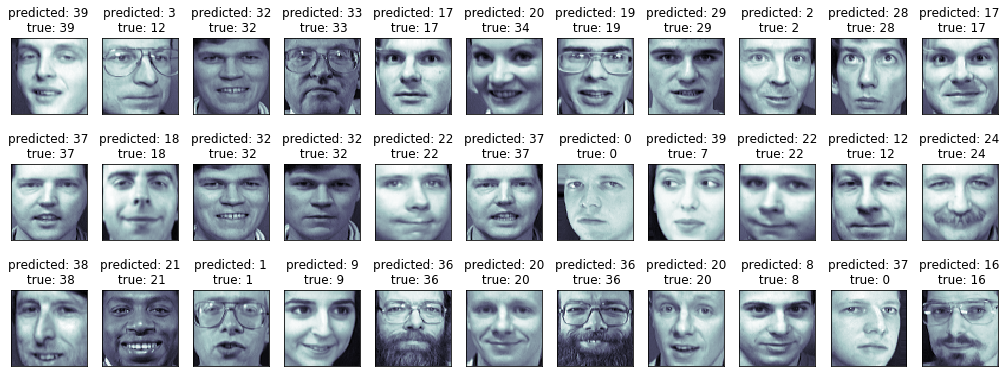

In [70]:
# showing comparison of actual values with predicted ones
y_pred1=np.array(y_pred1)
prediction7 = [title(y_pred1,y_test,i) for i in range(y_pred1.shape[0])]
plot_gallery(x_test,prediction7,64,64)

## 6. LOGISTIC REGRESSION

 ### Wihout using PCA

In [71]:
lr=LogisticRegression()
start=time.time()
lr.fit(x_train,y_train)
end=time.time()
predd=lr.predict(x_test)

C:\Users\swaga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\swaga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [72]:
print('Accuracy score is',ac(y_test,predd))
print('Time taken is',(end-start))

Accuracy score is 0.97
Time taken is 13.273273229598999


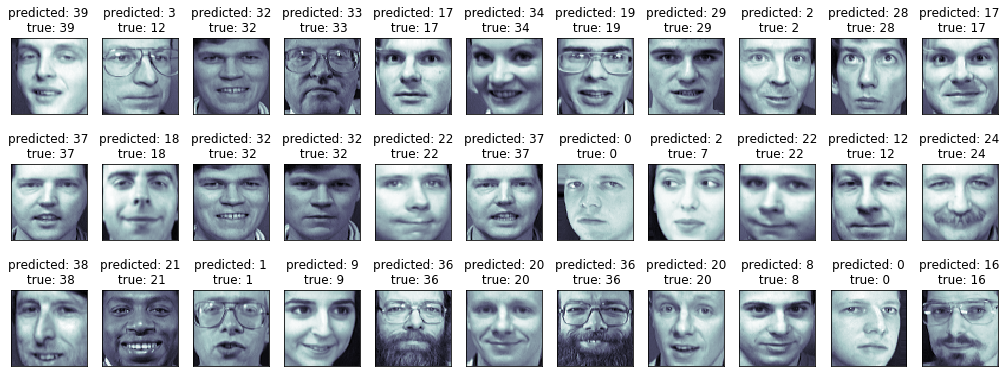

In [73]:
# showing comparison of actual values with predicted ones
prediction8 = [title(predd,y_test,i) for i in range(predd.shape[0])]
plot_gallery(x_test,prediction8,64,64)

### With PCA

In [74]:
start=time.time()
lr.fit(x_train_pca,y_train)
end=time.time()
predd2=lr.predict(x_test_pca)

C:\Users\swaga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\swaga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [75]:
print('Accuracy score is',ac(y_test,predd2))
print('Time taken is ',(end-start))

Accuracy score is 0.95
Time taken is  0.20398926734924316


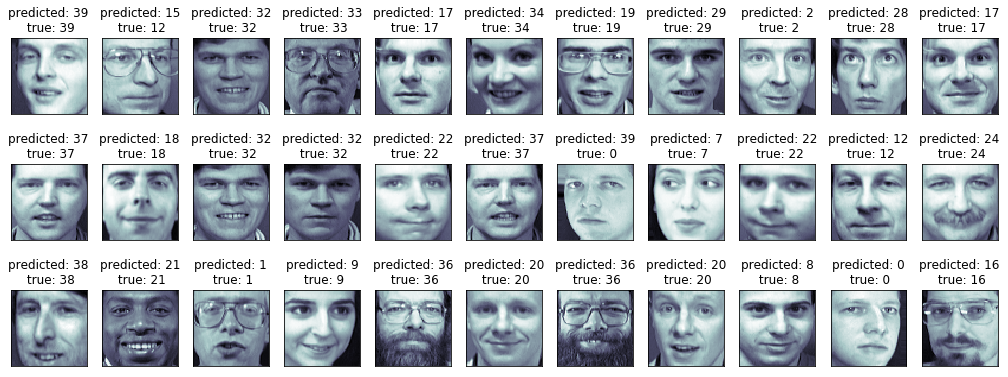

In [76]:
# showing comparison of actual values with predicted ones
prediction8 = [title(predd2,y_test,i) for i in range(predd2.shape[0])]
plot_gallery(x_test,prediction8,64,64)

#### ___________ start refers to the time at the start of fitting process and end represents the ending time_____

# _THE END_